In [1]:
import glob
import bz2, shutil, json
from tqdm import tqdm

import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.utils.class_weight import compute_class_weight

### Loading scores dump:

- `results_files` - includes the aggregated (per page) bert predicted scores 
- `full_results_files` - includes NOT aggregated (per sentence) bert predicted scores

The examples of the data used is provided in next cells: 


In [2]:
import pickle
with open('data/prediction_dump.pickle', 'rb') as handle:
    b = pickle.load(handle)

results_files = b["results_files"]
full_results_files = b["full_results_files"]

In [3]:
results_files.keys()

dict_keys(['readability/data/children-api_vikidia-it_text.bz2', 'readability/data/children-api_vikidia-oc_text.bz2', 'readability/data/children-api_vikidia-el_text.bz2', 'readability/data/children-api_vikidia-de_text.bz2', 'readability/data/children-api_vikidia-ru_text.bz2', 'readability/data/children-api_vikidia-es_text.bz2', 'readability/data/children-api_vikidia-en_text.bz2', 'readability/data/children-api_vikidia-ca_text.bz2', 'readability/data/children-api_vikidia-hy_text.bz2', 'readability/data/children-api_vikidia-scn_text.bz2', 'readability/data/children-api_vikidia-pt_text.bz2', 'readability/data/children-api_vikidia-fr_text.bz2', 'readability/data/children-api_vikidia-eu_text.bz2', 'readability/data/children-api_klexikon-de_text.bz2', 'readability/data/children-api_wikikids-nl_text.bz2', 'readability/data/txikipedia_text.bz2', 'data/simple-en-test.bz2', 'data/simple-en-validation.bz2'])

In [4]:
results_files['data/simple-en-test.bz2']

title  label                data_name      mean  \
0               'N'_Dey_Say      0  data/simple-en-test.bz2  0.182096   
1               'N'_Dey_Say      1  data/simple-en-test.bz2  0.530985   
2      100_Greatest_Britons      0  data/simple-en-test.bz2  0.273874   
3      100_Greatest_Britons      1  data/simple-en-test.bz2  0.758785   
4                 100_Tears      0  data/simple-en-test.bz2  0.018731   
...                     ...    ...                      ...       ...   
21827        Željko_Kopanja      0  data/simple-en-test.bz2  0.281310   
21828        Željko_Kopanja      1  data/simple-en-test.bz2  0.360484   
21829       ʻAkilisi_Pōhiva      0  data/simple-en-test.bz2  0.161534   
21830       ʻAkilisi_Pōhiva      1  data/simple-en-test.bz2  0.705170   
21831                ʻAlalā      0  data/simple-en-test.bz2  0.656384   

       sentence_count   pred  
0                   9  False  
1                   4   True  
2                   3  False  
3                   5   True  
4                   3  False  
...               ...    ...  
21827               5  False  
21828               3  False  
21829               4  False  
21830               3   True  
21831               3   True  

[21832 rows x 6 columns]

In [5]:
full_results_files['data/simple-en-test.bz2']

title  \
755859                    Hud_(surah)   
755860                    Hud_(surah)   
755861                    Hud_(surah)   
755862                    Hud_(surah)   
755863                 Albrecht_Dürer   
...                               ...   
913029  Swedish_Basketball_Federation   
913030  Swedish_Basketball_Federation   
913031  Swedish_Basketball_Federation   
913032  Swedish_Basketball_Federation   
913033  Swedish_Basketball_Federation   

                                                     text  label  \
755859  Hud (, ), is the 11th chapter (Surah) of the Q...      1   
755860             It relates in part to the prophet Hud.      1   
755861  Regarding the timing and contextual background...      1   
755862  Verses 105-112 are preserved in the Ṣan‘ā’1 lo...      1   
755863  Albrecht Dürer (; ; ; 21 May 1471 – 6 April 15...      1   
...                                                   ...    ...   
913029  The Swedish Basketball Federation () is a spec...      0   
913030             It was established on 25 October 1952.      0   
913031  It was established out of the Swedish Handball...      0   
913032  The Swedish Handball Federation's basketball s...      0   
913033                  Its headqarters are in Stockholm.      0   

                      data_name     score  
755859  data/simple-en-test.bz2  0.732055  
755860  data/simple-en-test.bz2  0.224110  
755861  data/simple-en-test.bz2  0.967706  
755862  data/simple-en-test.bz2  0.367458  
755863  data/simple-en-test.bz2  0.973148  
...                         ...       ...  
913029  data/simple-en-test.bz2  0.038036  
913030  data/simple-en-test.bz2  0.107664  
913031  data/simple-en-test.bz2  0.323829  
913032  data/simple-en-test.bz2  0.313983  
913033  data/simple-en-test.bz2  0.422319  

[157175 rows x 5 columns]

## Loading the initial data:

In [6]:
testing_datasets = [
 'readability/data/children-api_vikidia-it_text.bz2',
 'readability/data/children-api_vikidia-oc_text.bz2',
 'readability/data/children-api_vikidia-el_text.bz2',
 'readability/data/children-api_vikidia-de_text.bz2',
 'readability/data/children-api_vikidia-ru_text.bz2',
 'readability/data/children-api_vikidia-es_text.bz2',
 'readability/data/children-api_vikidia-en_text.bz2',
 'readability/data/children-api_vikidia-ca_text.bz2',
 'readability/data/children-api_vikidia-hy_text.bz2',
 'readability/data/children-api_vikidia-scn_text.bz2',
 'readability/data/children-api_vikidia-pt_text.bz2',
 'readability/data/children-api_vikidia-fr_text.bz2',
 'readability/data/children-api_vikidia-eu_text.bz2',
 'readability/data/children-api_klexikon-de_text.bz2',
 'readability/data/children-api_wikikids-nl_text.bz2',
 'readability/data/txikipedia_text.bz2',
 'data/simple-en-validation.bz2',
 'data/simple-en-test.bz2',
]

data = {}
for file in tqdm(testing_datasets):
    data_cc = []
    if (file != 'data/simple-en-test.bz2') and (file != 'data/simple-en-validation.bz2'):
        with bz2.open(file,"rt") as fin:
            for line in fin:
                dict_in = json.loads(line)
                data_cc.append(dict_in)
    else:
        with open(file, 'r') as fout:
            for line in fout:
                dict_in = json.loads(line)
                data_cc.append(dict_in)
    data[file] = data_cc

100%|██████████| 18/18 [00:06<00:00,  2.89it/s]


## Initialization the function for FK score calculation
(can be used properly only for English texts)

In [7]:
import textstat
def fk_score(text):
    try:
        return textstat.flesch_kincaid_grade(text)
    except:
        return None

# Building fk_model (ONLY ENGLISH TRAINING): 

Features used: 
- bert scores for the first 15 sentences
- mean bert score for the first 15 sentences
- max bert score for the first 15 sentences
- min bert score for the first 15 sentences

### Data preparation:

In [8]:
full_text_dict = {f: {"easy": {}, "hard": {}} for f in data.keys()}
for file, data_tmp in data.items():
    for element in data_tmp: 
        full_text_dict[file]["easy"][element["easy"]["title"]] = element["easy"]["text"]
        full_text_dict[file]["hard"][element["hard"]["title"]] = element["hard"]["text"]

In [9]:
filename = 'data/simple-en-test.bz2'
full_text_dict[filename]["hard"]["Hello_Fascination"]

['Hello Fascination is the second studio album by electronic rock duo Breathe Carolina.',
 'It was released on August 18, 2009 through Fearless Records.',
 'It was produced by Mike Green and Matt Squire.']

In [10]:
sentences_scores = {}
for filename in full_results_files.keys():
    sentences_scores.update({k:v for k,v in zip(full_results_files[filename].text, full_results_files[filename].score)})

In [11]:
sentences_scores["Its headqarters are in Stockholm."]

0.422318696975708

In [12]:
# rate of full texts included
(results_files[filename].sentence_count<15).mean()

0.9193311956023821

In [13]:
def pad_list(a, PAD_TOKEN=-1, N=15):
    a = (a + N * [PAD_TOKEN])[:N]
    return a

In [14]:
langs_dict = {
 'readability/data/children-api_vikidia-it_text.bz2': 'it',
 'readability/data/children-api_vikidia-oc_text.bz2': 'oc',
 'readability/data/children-api_vikidia-el_text.bz2': 'el',
 'readability/data/children-api_vikidia-de_text.bz2': 'de-vikidia',
 'readability/data/children-api_vikidia-ru_text.bz2': 'ru',
 'readability/data/children-api_vikidia-es_text.bz2': 'es',
 'readability/data/children-api_vikidia-en_text.bz2': 'en-vikidia',
 'readability/data/children-api_vikidia-ca_text.bz2': 'ca',
 'readability/data/children-api_vikidia-hy_text.bz2': 'hy',
 'readability/data/children-api_vikidia-scn_text.bz2': 'scn',
 'readability/data/children-api_vikidia-pt_text.bz2': 'pt',
 'readability/data/children-api_vikidia-fr_text.bz2': 'fr',
 'readability/data/children-api_vikidia-eu_text.bz2': 'eu-vikidia',
 'readability/data/children-api_klexikon-de_text.bz2': 'de-klexikon',
 'readability/data/children-api_wikikids-nl_text.bz2': 'nl',
 'readability/data/txikipedia_text.bz2': 'eu',
 'data/simple-en-test.bz2': 'en-test',
 'data/simple-en-validation.bz2': 'en-validation'
}

In [16]:
text_features = []
labels = []
languages = []
mean_score = []
max_score = []
min_score = []
titles = []
fk_scores = []
for filename in tqdm(results_files.keys()):
    # building scores dataset:
    labels += results_files[filename].label.to_list()
    languages += [langs_dict[filename]] * len(results_files[filename])
    mean_score +=  results_files[filename]['mean'].to_list()
    titles +=  results_files[filename]['title'].to_list()
    for _, row in results_files[filename].iterrows():
        title = row.title
        label = "easy" if row.label == 0 else "hard"
        local_list = []
        for sentence in full_text_dict[filename][label][title]:
            local_list.append(sentences_scores[sentence])
        local_list_pad = pad_list(local_list)
        text_features.append(local_list_pad)
        max_score.append(np.max(local_list))
        min_score.append(np.min(local_list))
        
    ##### Calculating FK score for english:
    if langs_dict[filename] in ['en-vikidia', 'en-validation', 'en-test']:
        tmp_df = results_files[filename]
        scores = []
        for label, title in zip(tmp_df.label, tmp_df.title):
            text = full_text_dict[filename]["easy" if label==0 else "hard"][title]
            scores.append({"fk_score": fk_score(" ".join(text))})
        fk_scores += [s["fk_score"] for s in scores]
        print(len(fk_scores))
    else:
        fk_scores += [None] * len(results_files[filename])
        

 50%|█████     | 9/18 [00:03<00:03,  2.40it/s]

13146


 94%|█████████▍| 17/18 [00:18<00:02,  2.91s/it]

97690


100%|██████████| 18/18 [00:26<00:00,  1.47s/it]

119520


### building basic model: 

In [17]:
train_df = pd.DataFrame(text_features, columns=[f"sent_{i}" for i in range(1, 16)])
train_df["language"] = languages
train_df["is_hard"] = labels
train_df["bert_score_mean"] = mean_score
train_df["bert_score_min"] = min_score
train_df["bert_score_max"] = max_score
train_df["title"] = titles
train_df["fk_score"] = fk_scores
train_df

sent_1    sent_2    sent_3    sent_4    sent_5    sent_6    sent_7  \
0       0.846135  0.773939  0.403176  0.741274  0.943109  0.828030  0.619938   
1       0.970994  0.934516  0.735772  0.706069  0.815482  0.532859  0.774909   
2       0.063304  0.918767  0.634324  0.137227  0.322618 -1.000000 -1.000000   
3       0.500233  0.879171  0.882425  0.367710  0.927977  0.476741 -1.000000   
4       0.486620  0.578526  0.490645 -1.000000 -1.000000 -1.000000 -1.000000   
...          ...       ...       ...       ...       ...       ...       ...   
119515  0.072262  0.575820  0.041784  0.042342  0.166968  0.079448 -1.000000   
119516  0.045024  0.406263  0.052316  0.315815  0.671547  0.497747  0.026699   
119517  0.903082  0.272369  0.314781 -1.000000 -1.000000 -1.000000 -1.000000   
119518  0.954134  0.941667  0.936734  0.966434  0.904092  0.792943 -1.000000   
119519  0.042473  0.766068  0.563927  0.430425 -1.000000 -1.000000 -1.000000   

          sent_8    sent_9   sent_10  ...   sent_13   sent_14  sent_15  \
0       0.771344  0.757939  0.531559  ...  0.608507 -1.000000     -1.0   
1       0.633123  0.677271  0.737581  ...  0.890823  0.714675     -1.0   
2      -1.000000 -1.000000 -1.000000  ... -1.000000 -1.000000     -1.0   
3      -1.000000 -1.000000 -1.000000  ... -1.000000 -1.000000     -1.0   
4      -1.000000 -1.000000 -1.000000  ... -1.000000 -1.000000     -1.0   
...          ...       ...       ...  ...       ...       ...      ...   
119515 -1.000000 -1.000000 -1.000000  ... -1.000000 -1.000000     -1.0   
119516  0.056684  0.330427  0.292352  ... -1.000000 -1.000000     -1.0   
119517 -1.000000 -1.000000 -1.000000  ... -1.000000 -1.000000     -1.0   
119518 -1.000000 -1.000000 -1.000000  ... -1.000000 -1.000000     -1.0   
119519 -1.000000 -1.000000 -1.000000  ... -1.000000 -1.000000     -1.0   

             language  is_hard bert_score_mean  bert_score_min  \
0                  it        0        0.736844        0.403176   
1                  it        1        0.768468        0.532859   
2                  it        0        0.415248        0.063304   
3                  it        1        0.672376        0.367710   
4                  it        0        0.518597        0.486620   
...               ...      ...             ...             ...   
119515  en-validation        0        0.163104        0.041784   
119516  en-validation        0        0.269488        0.026699   
119517  en-validation        1        0.496744        0.272369   
119518  en-validation        1        0.916001        0.792943   
119519  en-validation        0        0.450723        0.042473   

        bert_score_max                title  fk_score  
0             0.943109                 AIDS       NaN  
1             0.970994                 AIDS       NaN  
2             0.918767          Abano_Terme       NaN  
3             0.927977          Abano_Terme       NaN  
4             0.578526              Abbazia       NaN  
...                ...                  ...       ...  
119515        0.575820    Ōsumi_(satellite)       7.8  
119516        0.671547            Şeref_Has       4.3  
119517        0.903082            Şeref_Has       8.2  
119518        0.966434  Γ-Aminobutyric_acid      10.9  
119519        0.766068          ’O_sole_mio       7.9  

[119520 rows x 22 columns]

In [19]:
features = [f"sent_{i}" for i in range(1, 16)] + ["bert_score_mean", "bert_score_max", "bert_score_min"]
target_column = 'fk_score'


X_train = train_df[train_df.language == 'en-validation'][features]
X_test = train_df[train_df.language == 'en-test'][features]
X_val = train_df[train_df.language == 'en-vikidia'][features]
y_train = train_df[train_df.language == 'en-validation'][target_column]
y_test = train_df[train_df.language == 'en-test'][target_column]
y_val = train_df[train_df.language == 'en-vikidia'][target_column]


cat_features = [] #+ user_features

train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)
test_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)


# Initialize CatBoostClassifier
model = CatBoostRegressor(iterations=5000, metric_period=100, verbose=True, learning_rate=0.01,
                           # task_type="GPU",
                           custom_metric=['RMSE', "MAE"])
# Fit model
model.fit(train_data, eval_set=test_data, plot=False, use_best_model=True)

print(model.best_score_)
print(pd.DataFrame({
    'feature_importance': model.get_feature_importance(train_data),
    'feature_names': X_test.columns}
).sort_values(by=['feature_importance'], ascending=False).head(30))

model.save_model('fk_scores.bin')

# model = CatBoostRegressor()
# model.load_model('fk_scores.bin')

0:	learn: 3.1335737	test: 3.1623732	best: 3.1623732 (0)	total: 61.8ms	remaining: 5m 8s
100:	learn: 2.4101995	test: 2.4364988	best: 2.4364988 (100)	total: 400ms	remaining: 19.4s
200:	learn: 2.2666411	test: 2.2918629	best: 2.2918629 (200)	total: 711ms	remaining: 17s
300:	learn: 2.2285331	test: 2.2557477	best: 2.2557477 (300)	total: 1.02s	remaining: 16s
400:	learn: 2.2091089	test: 2.2406307	best: 2.2406307 (400)	total: 1.33s	remaining: 15.3s
500:	learn: 2.1966795	test: 2.2330893	best: 2.2330893 (500)	total: 1.65s	remaining: 14.8s
600:	learn: 2.1868301	test: 2.2279981	best: 2.2279981 (600)	total: 1.96s	remaining: 14.3s
700:	learn: 2.1787827	test: 2.2243002	best: 2.2243002 (700)	total: 2.27s	remaining: 13.9s
800:	learn: 2.1709064	test: 2.2208902	best: 2.2208902 (800)	total: 2.59s	remaining: 13.6s
900:	learn: 2.1640614	test: 2.2184630	best: 2.2184630 (900)	total: 2.9s	remaining: 13.2s
1000:	learn: 2.1572897	test: 2.2162641	best: 2.2162641 (1000)	total: 3.2s	remaining: 12.8s
1100:	learn: 2.15

In [20]:
# X_test["pred_proba"] = model.predict_proba(X_test[features])[:, 1]
X_test["fk_pred"] = model.predict(X_test[features])
X_test["fk_score"] = y_test
X_test["is_hard"] = train_df[train_df.language == 'en-test']["is_hard"]

In [24]:
# X_test["pred_proba"] = model.predict_proba(X_test[features])[:, 1]
X_val["fk_pred"] = model.predict(X_val[features])
X_val["fk_score"] = y_val
X_val["is_hard"] = train_df[train_df.language == 'en-vikidia']["is_hard"]

### Validating on simplewiki holdout

In [22]:
sns.displot(data=X_test, x='fk_pred', hue='is_hard', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
plt.title("FK-score predicted based on BERT scores for ENGLISH (simplewiki)")
plt.plot()

[]

[]

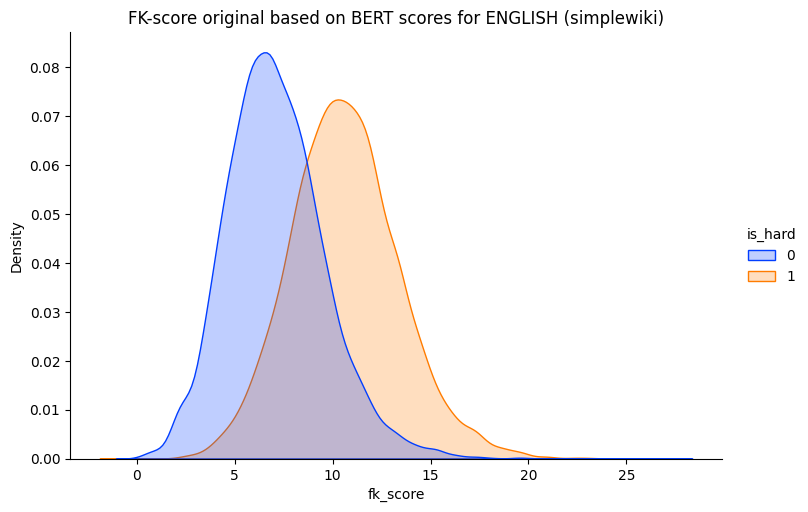

In [23]:
sns.displot(data=X_test, x='fk_score', hue='is_hard', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
plt.title("FK-score original based on BERT scores for ENGLISH (simplewiki)")
plt.plot()

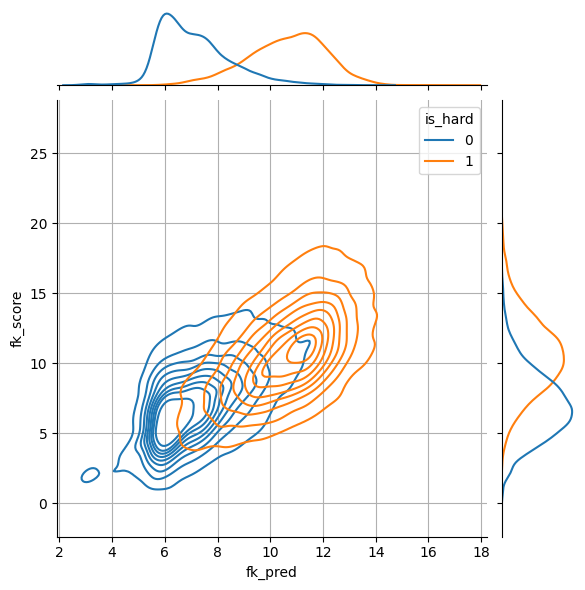

In [36]:
sns.jointplot(data=X_test, x="fk_pred", y="fk_score", kind="kde", hue="is_hard")
plt.grid()

### Validating on vikidia holdout

[]

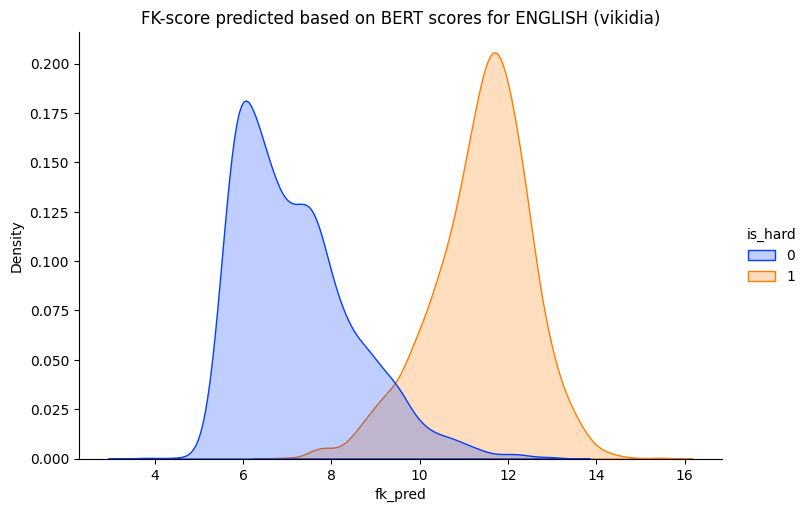

In [25]:
sns.displot(data=X_val, x='fk_pred', hue='is_hard', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
plt.title("FK-score predicted based on BERT scores for ENGLISH (vikidia)")
plt.plot()

In [26]:
sns.displot(data=X_val, x='fk_score', hue='is_hard', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
plt.title("FK-score original based on BERT scores for ENGLISH (vikidia)")
plt.plot()

[]

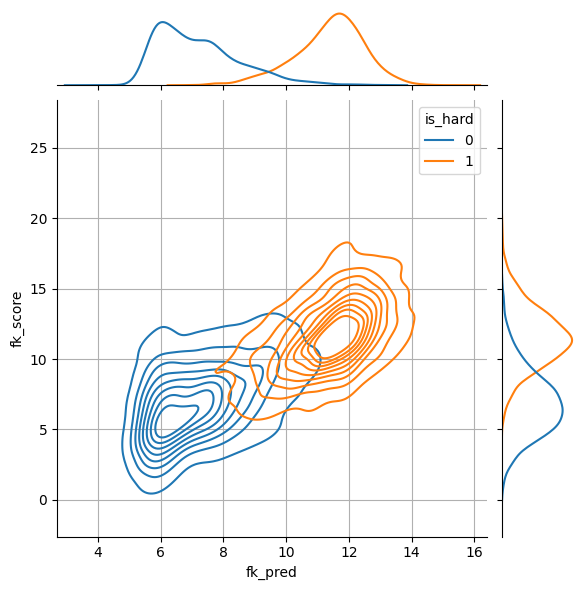

In [37]:
sns.jointplot(data=X_val, x="fk_pred", y="fk_score", kind="kde", hue="is_hard")
plt.grid()

### Checking performance on non-english

[]

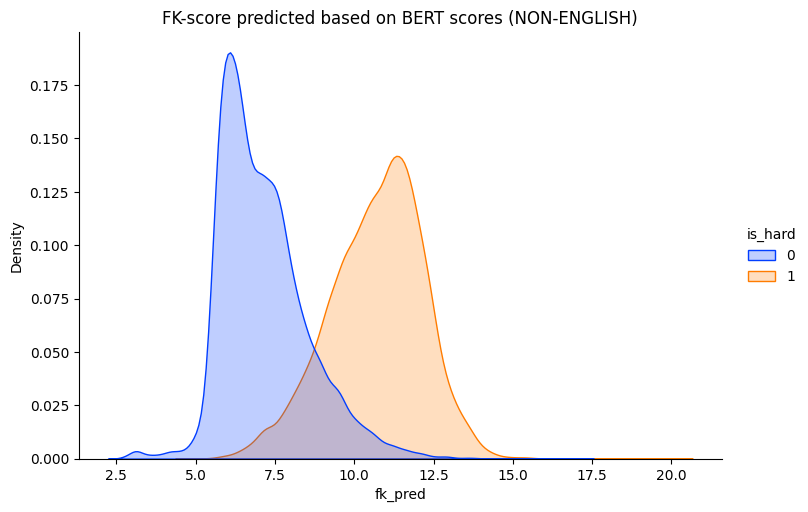

In [29]:
X_nonenglish = train_df[train_df.language.isin(['en-validation', 'en-test', 'en-vikidia'])]
X_nonenglish['fk_pred'] = model.predict(X_nonenglish[features])

sns.displot(data=X_nonenglish, x='fk_pred', hue='is_hard', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
plt.title("FK-score predicted based on BERT scores (NON-ENGLISH)")
plt.plot()

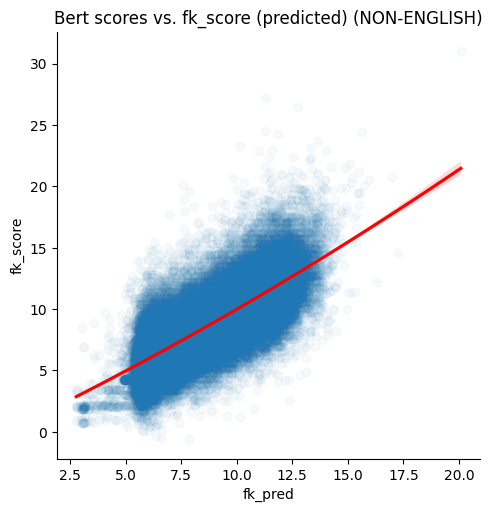

In [30]:
# draw regplot
sns.lmplot( x = "fk_pred",
            y = "fk_score",
            data = X_nonenglish,
            scatter_kws={'alpha':0.03},
            line_kws={"color": "red"},
            order=2)
 
# show the plot
plt.title("Bert scores vs. fk_score (predicted) (NON-ENGLISH)")
plt.xlabel("fk_pred")
plt.show()

In [31]:
X_nonenglish[["fk_score", "fk_pred"]].corr("spearman")

fk_score   fk_pred
fk_score  1.000000  0.751062
fk_pred   0.751062  1.000000

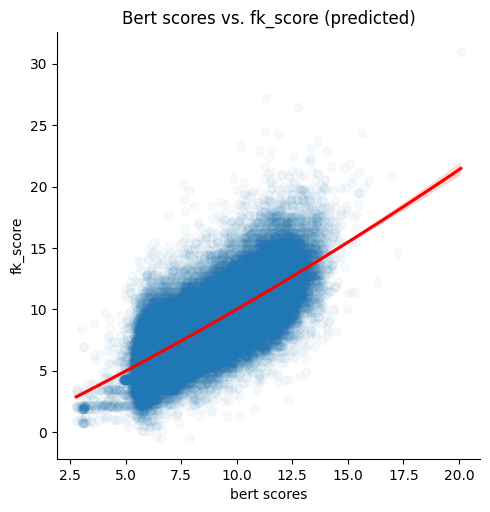

In [32]:
# draw regplot
sns.lmplot( x = "fk_pred",
            y = "fk_score",
            data = X_nonenglish,
            scatter_kws={'alpha':0.03},
            line_kws={"color": "red"},
            order=2)
 
# show the plot
plt.title("Bert scores vs. fk_score (predicted)")
plt.xlabel("bert scores")
plt.show()

In [33]:
# draw regplot
sns.lmplot( x = "fk_pred",
            y = "fk_score",
            data = X_nonenglish,
            scatter_kws={'alpha':0.03},
            line_kws={"color": "red"},
            order=2,
            col="is_hard")
 
# show the plot
plt.xlabel("bert scores")
plt.show()